In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn
import sklearn
import sklearn.preprocessing as pre
from scipy.stats import norm
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
 
from scipy.spatial.distance import cdist

%matplotlib inline

pd.set_option('max_columns', None)

==========================================================
## Data Input and Data Preprocessing 
==========================================================

In [2]:
#Read deviation file = export from database
df_f_dev_ld = pd.read_csv('feature_ibor_abor_deviation_9PF.csv', sep=';')
df_f_dev_ld.head(10)


,PORTFOLIO_CODE,EFFECTIVE_DATE,MARKET_VALUE_DIRTY_PORTFOLIO,OPRH_TOTAL_AMOUNT_BASE,DEVIATION_IN_PERCENT_OF_IBOR
0,A-AA25,2019-11-04 00:00:00.000,4.855158e+08,484074025.6,0.002970
1,A-AA25,2019-11-05 00:00:00.000,4.897845e+08,488636111.7,0.002345
2,A-AA25,2019-11-06 00:00:00.000,4.898977e+08,488152563.0,0.003562
3,A-AA25,2019-11-07 00:00:00.000,4.926490e+08,491071123.4,0.003203
4,A-AA25,2019-11-08 00:00:00.000,4.911470e+08,489895646.5,0.002548
5,A-AA25,2019-11-11 00:00:00.000,4.810345e+08,480358054.1,0.001406
6,A-AA25,2019-11-12 00:00:00.000,4.828674e+08,482542382.6,0.000673
7,A-AA25,2019-11-13 00:00:00.000,4.797869e+08,477039980.9,0.005725
8,A-AA25,2019-11-14 00:00:00.000,4.773435e+08,476580318.5,0.001599
9,A-AA25,2019-11-15 00:00:00.000,4.754048e+08,476341668.8,-0.001971


In [3]:
df_f_dev_ld.shape

(2942, 5)

In [4]:
#Read region file = export from database
df_f_region_ld = pd.read_csv('feature_ibor_region_9PF.csv', sep=';')
df_f_region_ld.head(10)

,EFFECTIVE_DATE,PORTFOLIO_CODE,REGION,PERCENTAGE_REGION
0,2020-09-22 00:00:00.000,Y-B58,Europe,0.861770
1,2020-07-21 00:00:00.000,F-G5678,Oceania,0.000332
2,2020-12-28 00:00:00.000,F-G593,Oceania,0.001630
3,2020-11-10 00:00:00.000,F-G1064,Asia,0.011110
4,2021-01-22 00:00:00.000,F-G5678,Europe,0.923896
5,2020-12-22 00:00:00.000,Y-C79,Asia,0.007392
6,2020-01-09 00:00:00.000,F-G5678,Asia,0.027305
7,2020-09-11 00:00:00.000,Y-B58,Asia,0.022074
8,2020-04-29 00:00:00.000,Y-C79,Europe,0.977177
9,2021-02-11 00:00:00.000,F-S3699,Europe,0.896486


In [5]:
#Read asset_type file = export from database
df_f_atype_ld = pd.read_csv('feature_ibor_asset_type_9PF.csv', sep=';')
df_f_atype_ld.head(10)


,EFFECTIVE_DATE,PORTFOLIO_CODE,ASSET_TYPE,PERCENTAGE_ASSET_TYPE
0,2020-08-21 00:00:00.000,Y-C79,Funds,0.057521
1,2020-07-23 00:00:00.000,F-G5678,Debts,0.336440
2,2020-10-05 00:00:00.000,F-G593,Forward,-0.000430
3,2020-12-03 00:00:00.000,F-G760,Futures,0.000000
4,2020-09-16 00:00:00.000,F-G593,Forward,-0.000208
5,2020-07-17 00:00:00.000,A-AA25,Forward,0.000006
6,2020-05-26 00:00:00.000,Y-C79,Debts,0.933533
7,2020-08-24 00:00:00.000,F-G1789,Debts,0.621143
8,2021-01-29 00:00:00.000,F-G593,Funds,0.175032
9,2020-03-25 00:00:00.000,F-G1064,Futures,0.000000


In [6]:
df_f_atype_ld.shape

(14564, 4)

In [7]:
# put values of asset type into column by pivoting
df_f_atype_ld.sort_values(by=['EFFECTIVE_DATE', 'PORTFOLIO_CODE'])

df_f_atype_piv=df_f_atype_ld.pivot_table( values='PERCENTAGE_ASSET_TYPE',index=['EFFECTIVE_DATE', 'PORTFOLIO_CODE'], columns=['ASSET_TYPE'])

df_f_atype_piv.head(10)

ASSET_TYPE                                  Cash     Debts  Equities  \
EFFECTIVE_DATE          PORTFOLIO_CODE                                 
2019-11-04 00:00:00.000 A-AA25          0.012110       NaN  0.987858   
                        F-G1064         0.011519  0.583911       NaN   
                        F-G1789         0.038335  0.596810  0.363265   
                        F-G5678         0.099929  0.438158       NaN   
                        F-G593          0.027206  0.597330  0.192623   
                        F-G760          0.006668  0.577288  0.253423   
                        F-S3699         0.019924  0.329435  0.638094   
                        Y-B58           0.027819  0.962720       NaN   
                        Y-C79           0.008234  0.906783       NaN   
2019-11-05 00:00:00.000 A-AA25          0.015321       NaN  0.984646   

ASSET_TYPE                               Forward     Funds  Futures  \
EFFECTIVE_DATE          PORTFOLIO_CODE                                
2019-11-04 00:00:00.000 A-AA25          0.000032       NaN      NaN   
                        F-G1064              NaN  0.404391      0.0   
                        F-G1789              NaN  0.001590      0.0   
                        F-G5678              NaN  0.461913      0.0   
                        F-G593               NaN  0.182840      0.0   
                        F-G760               NaN  0.162621      0.0   
                        F-S3699              NaN  0.012547      NaN   
                        Y-B58           0.000147  0.009315      NaN   
                        Y-C79           0.000500  0.084864      0.0   
2019-11-05 00:00:00.000 A-AA25          0.000033       NaN      NaN   

ASSET_TYPE                              Listed Options  OTC Option  Rights  \
EFFECTIVE_DATE          PORTFOLIO_CODE                                       
2019-11-04 00:00:00.000 A-AA25                     NaN         NaN     NaN   
                        F-G1064                0.00018         NaN     NaN   
                        F-G1789                    NaN         NaN     NaN   
                        F-G5678                    NaN         NaN     NaN   
                        F-G593                     NaN         NaN     NaN   
                        F-G760                     NaN         NaN     NaN   
                        F-S3699                    NaN         NaN     NaN   
                        Y-B58                      NaN         NaN     NaN   
                        Y-C79                  0.00013    0.000028     NaN   
2019-11-05 00:00:00.000 A-AA25                     NaN         NaN     NaN   

ASSET_TYPE                                 Swaps  unknown_atype  
EFFECTIVE_DATE          PORTFOLIO_CODE                           
2019-11-04 00:00:00.000 A-AA25               NaN            NaN  
                        F-G1064              NaN            NaN  
                        F-G1789              NaN            NaN  
                        F-G5678              NaN            NaN  
                        F-G593               NaN            NaN  
                        F-G760               NaN            NaN  
                        F-S3699              NaN            NaN  
                        Y-B58                NaN            NaN  
                        Y-C79          -0.000538            NaN  
2019-11-05 00:00:00.000 A-AA25               NaN            NaN

In [8]:
# Fill NaN with 0 which is logically the correct value
df_f_atype_piv.fillna(0, inplace=True)

df_f_atype_piv.head(100)


ASSET_TYPE                                  Cash     Debts  Equities  \
EFFECTIVE_DATE          PORTFOLIO_CODE                                 
2019-11-04 00:00:00.000 A-AA25          0.012110  0.000000  0.987858   
                        F-G1064         0.011519  0.583911  0.000000   
                        F-G1789         0.038335  0.596810  0.363265   
                        F-G5678         0.099929  0.438158  0.000000   
                        F-G593          0.027206  0.597330  0.192623   
...                                          ...       ...       ...   
2019-11-18 00:00:00.000 F-G760          0.006475  0.574628  0.254465   
                        F-S3699         0.011769  0.337702  0.642961   
                        Y-B58           0.044206  0.946463  0.000000   
                        Y-C79           0.037121  0.879141  0.000000   
2019-11-19 00:00:00.000 A-AA25          0.021027  0.000000  0.978976   

ASSET_TYPE                               Forward     Funds  Futures  \
EFFECTIVE_DATE          PORTFOLIO_CODE                                
2019-11-04 00:00:00.000 A-AA25          0.000032  0.000000      0.0   
                        F-G1064         0.000000  0.404391      0.0   
                        F-G1789         0.000000  0.001590      0.0   
                        F-G5678         0.000000  0.461913      0.0   
                        F-G593          0.000000  0.182840      0.0   
...                                          ...       ...      ...   
2019-11-18 00:00:00.000 F-G760          0.000000  0.164431      0.0   
                        F-S3699         0.000000  0.007569      0.0   
                        Y-B58           0.000053  0.009278      0.0   
                        Y-C79          -0.000264  0.088373      0.0   
2019-11-19 00:00:00.000 A-AA25         -0.000003  0.000000      0.0   

ASSET_TYPE                              Listed Options  OTC Option  Rights  \
EFFECTIVE_DATE          PORTFOLIO_CODE                                       
2019-11-04 00:00:00.000 A-AA25                0.000000    0.000000     0.0   
                        F-G1064               0.000180    0.000000     0.0   
                        F-G1789               0.000000    0.000000     0.0   
                        F-G5678               0.000000    0.000000     0.0   
                        F-G593                0.000000    0.000000     0.0   
...                                                ...         ...     ...   
2019-11-18 00:00:00.000 F-G760                0.000000    0.000000     0.0   
                        F-S3699               0.000000    0.000000     0.0   
                        Y-B58                 0.000000    0.000000     0.0   
                        Y-C79                 0.000101   -0.003738     0.0   
2019-11-19 00:00:00.000 A-AA25                0.000000    0.000000     0.0   

ASSET_TYPE                                 Swaps  unknown_atype  
EFFECTIVE_DATE          PORTFOLIO_CODE                           
2019-11-04 00:00:00.000 A-AA25          0.000000            0.0  
                        F-G1064         0.000000            0.0  
                        F-G1789         0.000000            0.0  
                        F-G5678         0.000000            0.0  
                        F-G593          0.000000            0.0  
...                                          ...            ...  
2019-11-18 00:00:00.000 F-G760          0.000000            0.0  
                        F-S3699         0.000000            0.0  
                        Y-B58           0.000000            0.0  
                        Y-C79          -0.000733            0.0  
2019-11-19 00:00:00.000 A-AA25          0.000000            0.0  

[100 rows x 11 columns]

In [9]:
# put values of region into column by pivoting
df_f_region_ld.sort_values(by=['EFFECTIVE_DATE', 'PORTFOLIO_CODE'])

df_f_region_piv=df_f_region_ld.pivot_table( values='PERCENTAGE_REGION',index=['EFFECTIVE_DATE', 'PORTFOLIO_CODE'], columns=['REGION'])

df_f_region_piv.head(10)



REGION                                    Africa  Americas      Asia  \
EFFECTIVE_DATE          PORTFOLIO_CODE                                 
2019-11-04 00:00:00.000 A-AA25               NaN  0.011357  0.988471   
                        F-G1064              NaN  0.048523  0.013242   
                        F-G1789              NaN  0.015505  0.004241   
                        F-G5678              NaN  0.032410  0.027427   
                        F-G593               NaN       NaN       NaN   
                        F-G760               NaN  0.019141  0.003803   
                        F-S3699              NaN  0.106325       NaN   
                        Y-B58                NaN  0.098660  0.020439   
                        Y-C79           0.004599 -0.034056  0.002566   
2019-11-05 00:00:00.000 A-AA25               NaN  0.015185  0.984543   

REGION                                    Europe  InternationalOrg   Oceania  \
EFFECTIVE_DATE          PORTFOLIO_CODE                                         
2019-11-04 00:00:00.000 A-AA25          0.000172               NaN       NaN   
                        F-G1064         0.917872          0.017940  0.002423   
                        F-G1789         0.974746          0.003258  0.002249   
                        F-G5678         0.933506               NaN  0.006658   
                        F-G593          0.988933          0.011067       NaN   
                        F-G760          0.958160          0.018895       NaN   
                        F-S3699         0.893675               NaN       NaN   
                        Y-B58           0.864276          0.016625       NaN   
                        Y-C79           1.028349          0.006772 -0.008238   
2019-11-05 00:00:00.000 A-AA25          0.000273               NaN       NaN   

REGION                                  unknown_reg  
EFFECTIVE_DATE          PORTFOLIO_CODE               
2019-11-04 00:00:00.000 A-AA25                  NaN  
                        F-G1064                 NaN  
                        F-G1789                 NaN  
                        F-G5678                 NaN  
                        F-G593                  NaN  
                        F-G760                  NaN  
                        F-S3699                 NaN  
                        Y-B58                   NaN  
                        Y-C79              0.000008  
2019-11-05 00:00:00.000 A-AA25                  NaN

In [10]:
# Fill NaN with 0 which is logically the correct value
df_f_region_piv.fillna(0, inplace=True)

df_f_region_piv.head(100)


REGION                                    Africa  Americas      Asia  \
EFFECTIVE_DATE          PORTFOLIO_CODE                                 
2019-11-04 00:00:00.000 A-AA25          0.000000  0.011357  0.988471   
                        F-G1064         0.000000  0.048523  0.013242   
                        F-G1789         0.000000  0.015505  0.004241   
                        F-G5678         0.000000  0.032410  0.027427   
                        F-G593          0.000000  0.000000  0.000000   
...                                          ...       ...       ...   
2019-11-18 00:00:00.000 F-G760          0.000000  0.019246  0.004165   
                        F-S3699         0.000000  0.128696  0.001239   
                        Y-B58           0.000000  0.100934  0.019255   
                        Y-C79           0.004268 -0.013353  0.002379   
2019-11-19 00:00:00.000 A-AA25          0.000000  0.021315  0.978658   

REGION                                    Europe  InternationalOrg   Oceania  \
EFFECTIVE_DATE          PORTFOLIO_CODE                                         
2019-11-04 00:00:00.000 A-AA25          0.000172          0.000000  0.000000   
                        F-G1064         0.917872          0.017940  0.002423   
                        F-G1789         0.974746          0.003258  0.002249   
                        F-G5678         0.933506          0.000000  0.006658   
                        F-G593          0.988933          0.011067  0.000000   
...                                          ...               ...       ...   
2019-11-18 00:00:00.000 F-G760          0.957757          0.018832  0.000000   
                        F-S3699         0.870064          0.000000  0.000000   
                        Y-B58           0.863267          0.016543  0.000000   
                        Y-C79           1.002068          0.006246 -0.007604   
2019-11-19 00:00:00.000 A-AA25          0.000027          0.000000  0.000000   

REGION                                  unknown_reg  
EFFECTIVE_DATE          PORTFOLIO_CODE               
2019-11-04 00:00:00.000 A-AA25             0.000000  
                        F-G1064            0.000000  
                        F-G1789            0.000000  
                        F-G5678            0.000000  
                        F-G593             0.000000  
...                                             ...  
2019-11-18 00:00:00.000 F-G760             0.000000  
                        F-S3699            0.000000  
                        Y-B58              0.000000  
                        Y-C79              0.005997  
2019-11-19 00:00:00.000 A-AA25             0.000000  

[100 rows x 7 columns]

In [11]:
# check record counts of feature tables. Should be identical
print(df_f_dev_ld.count())
print(df_f_region_piv.count())
print(df_f_atype_piv.count())

PORTFOLIO_CODE                  2942
EFFECTIVE_DATE                  2942
MARKET_VALUE_DIRTY_PORTFOLIO    2942
OPRH_TOTAL_AMOUNT_BASE          2942
DEVIATION_IN_PERCENT_OF_IBOR    2942
dtype: int64
REGION
Africa              2942
Americas            2942
Asia                2942
Europe              2942
InternationalOrg    2942
Oceania             2942
unknown_reg         2942
dtype: int64
ASSET_TYPE
Cash              2942
Debts             2942
Equities          2942
Forward           2942
Funds             2942
Futures           2942
Listed Options    2942
OTC Option        2942
Rights            2942
Swaps             2942
unknown_atype     2942
dtype: int64


In [12]:
#Merge all 3 features together to the working dataframe for our further steps

df_merge1= pd.merge(df_f_dev_ld, df_f_region_piv, on =['EFFECTIVE_DATE','PORTFOLIO_CODE'])
df_merge1.head(10)


df_fset = pd.merge(df_merge1, df_f_atype_piv, on =['EFFECTIVE_DATE','PORTFOLIO_CODE'])
df_fset.head(100)



,PORTFOLIO_CODE,EFFECTIVE_DATE,MARKET_VALUE_DIRTY_PORTFOLIO,OPRH_TOTAL_AMOUNT_BASE,DEVIATION_IN_PERCENT_OF_IBOR,Africa,Americas,Asia,Europe,InternationalOrg,Oceania,unknown_reg,Cash,Debts,Equities,Forward,Funds,Futures,Listed Options,OTC Option,Rights,Swaps,unknown_atype
0,A-AA25,2019-11-04 00:00:00.000,4.855158e+08,484074025.6,0.002970,0.0,0.011357,0.988471,0.000172,0.0,0.0,0.0,0.012110,0.0,0.987858,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A-AA25,2019-11-05 00:00:00.000,4.897845e+08,488636111.7,0.002345,0.0,0.015185,0.984543,0.000273,0.0,0.0,0.0,0.015321,0.0,0.984646,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A-AA25,2019-11-06 00:00:00.000,4.898977e+08,488152563.0,0.003562,0.0,0.014814,0.985091,0.000095,0.0,0.0,0.0,0.015344,0.0,0.984623,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A-AA25,2019-11-07 00:00:00.000,4.926490e+08,491071123.4,0.003203,0.0,0.014541,0.986265,-0.000805,0.0,0.0,0.0,0.014469,0.0,0.985497,0.000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A-AA25,2019-11-08 00:00:00.000,4.911470e+08,489895646.5,0.002548,0.0,0.013950,0.986083,-0.000033,0.0,0.0,0.0,0.014526,0.0,0.985441,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,A-AA25,2020-03-20 00:00:00.000,3.209224e+08,321812013.0,-0.002772,0.0,0.024459,0.975524,0.000016,0.0,0.0,0.0,0.025534,0.0,0.974479,-0.000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,A-AA25,2020-03-23 00:00:00.000,3.095406e+08,309604448.7,-0.000206,0.0,0.025000,0.976186,-0.001186,0.0,0.0,0.0,0.025289,0.0,0.974723,-0.000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,A-AA25,2020-03-24 00:00:00.000,3.251301e+08,321907824.6,0.009911,0.0,0.025263,0.975687,-0.000950,0.0,0.0,0.0,0.024716,0.0,0.975292,-0.000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,A-AA25,2020-03-25 00:00:00.000,3.340692e+08,335639490.7,-0.004701,0.0,0.014462,0.985439,0.000099,0.0,0.0,0.0,0.015165,0.0,0.984847,-0.000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Cut out ABOR values which are not features

df_fset.drop('MARKET_VALUE_DIRTY_PORTFOLIO', axis=1, inplace=True)
df_fset.drop('OPRH_TOTAL_AMOUNT_BASE', axis=1, inplace=True)
df_fset.head(10)



,PORTFOLIO_CODE,EFFECTIVE_DATE,DEVIATION_IN_PERCENT_OF_IBOR,Africa,Americas,Asia,Europe,InternationalOrg,Oceania,unknown_reg,Cash,Debts,Equities,Forward,Funds,Futures,Listed Options,OTC Option,Rights,Swaps,unknown_atype
0,A-AA25,2019-11-04 00:00:00.000,0.002970,0.0,0.011357,0.988471,1.720498e-04,0.0,0.0,0.0,0.012110,0.0,0.987858,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A-AA25,2019-11-05 00:00:00.000,0.002345,0.0,0.015185,0.984543,2.726791e-04,0.0,0.0,0.0,0.015321,0.0,0.984646,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A-AA25,2019-11-06 00:00:00.000,0.003562,0.0,0.014814,0.985091,9.549372e-05,0.0,0.0,0.0,0.015344,0.0,0.984623,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A-AA25,2019-11-07 00:00:00.000,0.003203,0.0,0.014541,0.986265,-8.051695e-04,0.0,0.0,0.0,0.014469,0.0,0.985497,0.000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A-AA25,2019-11-08 00:00:00.000,0.002548,0.0,0.013950,0.986083,-3.314376e-05,0.0,0.0,0.0,0.014526,0.0,0.985441,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,A-AA25,2019-11-11 00:00:00.000,0.001406,0.0,0.013027,0.986961,1.133657e-05,0.0,0.0,0.0,0.015128,0.0,0.984839,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,A-AA25,2019-11-12 00:00:00.000,0.000673,0.0,0.017373,0.982461,1.660448e-04,0.0,0.0,0.0,0.017723,0.0,0.982244,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,A-AA25,2019-11-13 00:00:00.000,0.005725,0.0,0.022231,0.977677,9.204363e-05,0.0,0.0,0.0,0.022721,0.0,0.977247,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,A-AA25,2019-11-14 00:00:00.000,0.001599,0.0,0.021106,0.978894,-7.178260e-07,0.0,0.0,0.0,0.021464,0.0,0.978504,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,A-AA25,2019-11-15 00:00:00.000,-0.001971,0.0,0.013182,0.986523,2.953424e-04,0.0,0.0,0.0,0.014175,0.0,0.985827,-0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_fset.shape

(2942, 21)

In [15]:
# Organize data
# Split in index columns and data/featurecolumns
df_index = df_fset[['EFFECTIVE_DATE','PORTFOLIO_CODE']]
df_data = df_fset[['DEVIATION_IN_PERCENT_OF_IBOR','Africa','Americas','Asia','Europe',
                'InternationalOrg','Oceania','unknown_reg','Cash','Debts','Equities',
                'Forward','Funds','Futures','Listed Options', 'OTC Option','Rights',
                'Swaps','unknown_atype']]

df_data.head(10)


,DEVIATION_IN_PERCENT_OF_IBOR,Africa,Americas,Asia,Europe,InternationalOrg,Oceania,unknown_reg,Cash,Debts,Equities,Forward,Funds,Futures,Listed Options,OTC Option,Rights,Swaps,unknown_atype
0,0.002970,0.0,0.011357,0.988471,1.720498e-04,0.0,0.0,0.0,0.012110,0.0,0.987858,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002345,0.0,0.015185,0.984543,2.726791e-04,0.0,0.0,0.0,0.015321,0.0,0.984646,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003562,0.0,0.014814,0.985091,9.549372e-05,0.0,0.0,0.0,0.015344,0.0,0.984623,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003203,0.0,0.014541,0.986265,-8.051695e-04,0.0,0.0,0.0,0.014469,0.0,0.985497,0.000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002548,0.0,0.013950,0.986083,-3.314376e-05,0.0,0.0,0.0,0.014526,0.0,0.985441,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.001406,0.0,0.013027,0.986961,1.133657e-05,0.0,0.0,0.0,0.015128,0.0,0.984839,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000673,0.0,0.017373,0.982461,1.660448e-04,0.0,0.0,0.0,0.017723,0.0,0.982244,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.005725,0.0,0.022231,0.977677,9.204363e-05,0.0,0.0,0.0,0.022721,0.0,0.977247,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.001599,0.0,0.021106,0.978894,-7.178260e-07,0.0,0.0,0.0,0.021464,0.0,0.978504,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.001971,0.0,0.013182,0.986523,2.953424e-04,0.0,0.0,0.0,0.014175,0.0,0.985827,-0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:

df_data.shape

(2942, 19)

In [17]:
# Normalized data frame

df_norm = pd.DataFrame(pre.normalize(df_data, norm='l2'))

df_norm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.002125,0.000000,0.008126,0.707274,0.000123,0.000000,0.000000,0.000000,0.008665,0.000000,0.706836,0.000023,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,0.001684,0.000000,0.010904,0.706984,0.000196,0.000000,0.000000,0.000000,0.011002,0.000000,0.707058,0.000024,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,0.002557,0.000000,0.010635,0.707190,0.000069,0.000000,0.000000,0.000000,0.011016,0.000000,0.706853,0.000024,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,0.002297,0.000000,0.010428,0.707304,-0.000577,0.000000,0.000000,0.000000,0.010377,0.000000,0.706753,0.000025,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,0.001827,0.000000,0.010006,0.707262,-0.000024,0.000000,0.000000,0.000000,0.010419,0.000000,0.706802,0.000024,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,0.000522,0.002966,-0.027422,0.005135,0.736089,0.012831,-0.007130,0.001476,0.018233,0.675281,0.000000,-0.000019,0.028802,0.0,0.000295,0.000029,0.0,-0.000151,0.001476
2938,0.000657,0.002972,-0.027922,0.005157,0.735155,0.012884,-0.006242,0.004200,0.017204,0.676285,0.000000,-0.000462,0.028868,0.0,0.000228,0.000034,0.0,-0.000154,0.004200
2939,0.116233,0.002463,-0.023154,0.004279,0.721556,0.012974,-0.005138,0.006275,0.007709,0.681453,0.000000,-0.000199,0.023975,0.0,0.000143,0.000032,0.0,-0.000132,0.006275
2940,0.045252,0.002386,-0.022219,0.004150,0.745695,0.012613,-0.005084,0.006235,0.052645,0.661663,0.000000,-0.000113,0.023286,0.0,0.000173,0.000024,0.0,-0.000137,0.006235


==========================================================
# Statistics - Dimension 1
==========================================================

In [18]:
#Check the deviation

df_deviation = df_data['DEVIATION_IN_PERCENT_OF_IBOR']

df_deviation

0       0.002970
1       0.002345
2       0.003562
3       0.003203
4       0.002548
          ...   
2937    0.000721
2938    0.000904
2939    0.161601
2940    0.060841
2941    0.000053
Name: DEVIATION_IN_PERCENT_OF_IBOR, Length: 2942, dtype: float64

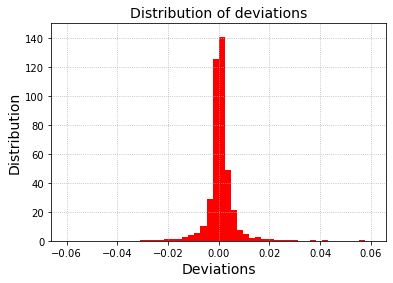

In [19]:
# Plot the deviation over all portfolios and dates

fig = plt.figure()
ax = fig.add_subplot()

# plot histogram 
ax.hist(df_deviation, bins=50, range=(-0.06,+0.06), density=True, color='red')

# add grid
ax.grid(linestyle='dotted')

# add axis range and legends
ax.set_xlabel("Deviations", fontsize=14)
ax.set_ylabel("Distribution", fontsize=14)

ax.set_ylim([0,150])

# add plot title
ax.set_title('Distribution of deviations', fontsize=14);



Deviation mean:  0.0011888888249694087
Standard deviation:  0.018925756537648775


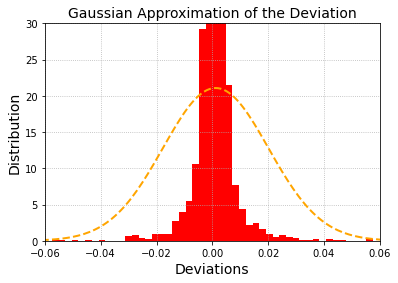

In [20]:
# Plot deviation distribution and normal distribution 
# based on mean and std of distribution
deviation_mean = np.mean(df_deviation)
deviation_std = np.std(df_deviation)

print("Deviation mean: ", deviation_mean)
print("Standard deviation: ", deviation_std)

# take fig and ax from aboveprepare plot
fig = plt.figure()
ax = fig.add_subplot()

# plot fitted "gaussian" or normal distribution
ax.plot(np.arange(-0.1, 0.1, 0.001), norm.pdf(np.arange(-0.1, 0.1, 0.001), deviation_mean, deviation_std), color='orange', linestyle='--', linewidth=2)

# plot histogram 
ax.hist(df_deviation, bins=50, range=(-0.06,+0.06), density=True, color='red')


# add grid
ax.grid(linestyle='dotted')

# add axis range and legends
ax.set_xlabel("Deviations", fontsize=14)
ax.set_ylabel("Distribution", fontsize=14)

ax.set_ylim([0,30])
ax.set_xlim([-0.06,0.06])

# add plot title
#ax.set_title('Distribution of deviations', fontsize=14);
# add plot title
ax.set_title('Gaussian Approximation of the Deviation', fontsize=14);

Deviation mean:  0.0011888888249694087
Standard deviation:  0.018925756537648775


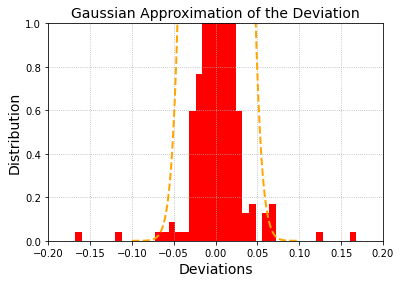

In [21]:
# Plot deviation distribution and normal distribution 
# based on mean and std of distribution
deviation_mean = np.mean(df_deviation)
deviation_std = np.std(df_deviation)

print("Deviation mean: ", deviation_mean)
print("Standard deviation: ", deviation_std)

# take fig and ax from aboveprepare plot
fig = plt.figure()
ax = fig.add_subplot()

# plot fitted "gaussian" or normal distribution
ax.plot(np.arange(-0.1, 0.1, 0.001), norm.pdf(np.arange(-0.1, 0.1, 0.001), deviation_mean, deviation_std), color='orange', linestyle='--', linewidth=2)

# plot histogram 
ax.hist(df_deviation, bins=50, range=(-0.2,+0.2), density=True, color='red')


# add grid
ax.grid(linestyle='dotted')

# add axis range and legends
ax.set_xlabel("Deviations", fontsize=14)
ax.set_ylabel("Distribution", fontsize=14)

ax.set_ylim([0,1])
ax.set_xlim([-0.2,0.2])

# add plot title
#ax.set_title('Distribution of deviations', fontsize=14);
# add plot title
ax.set_title('Gaussian Approximation of the Deviation', fontsize=14);

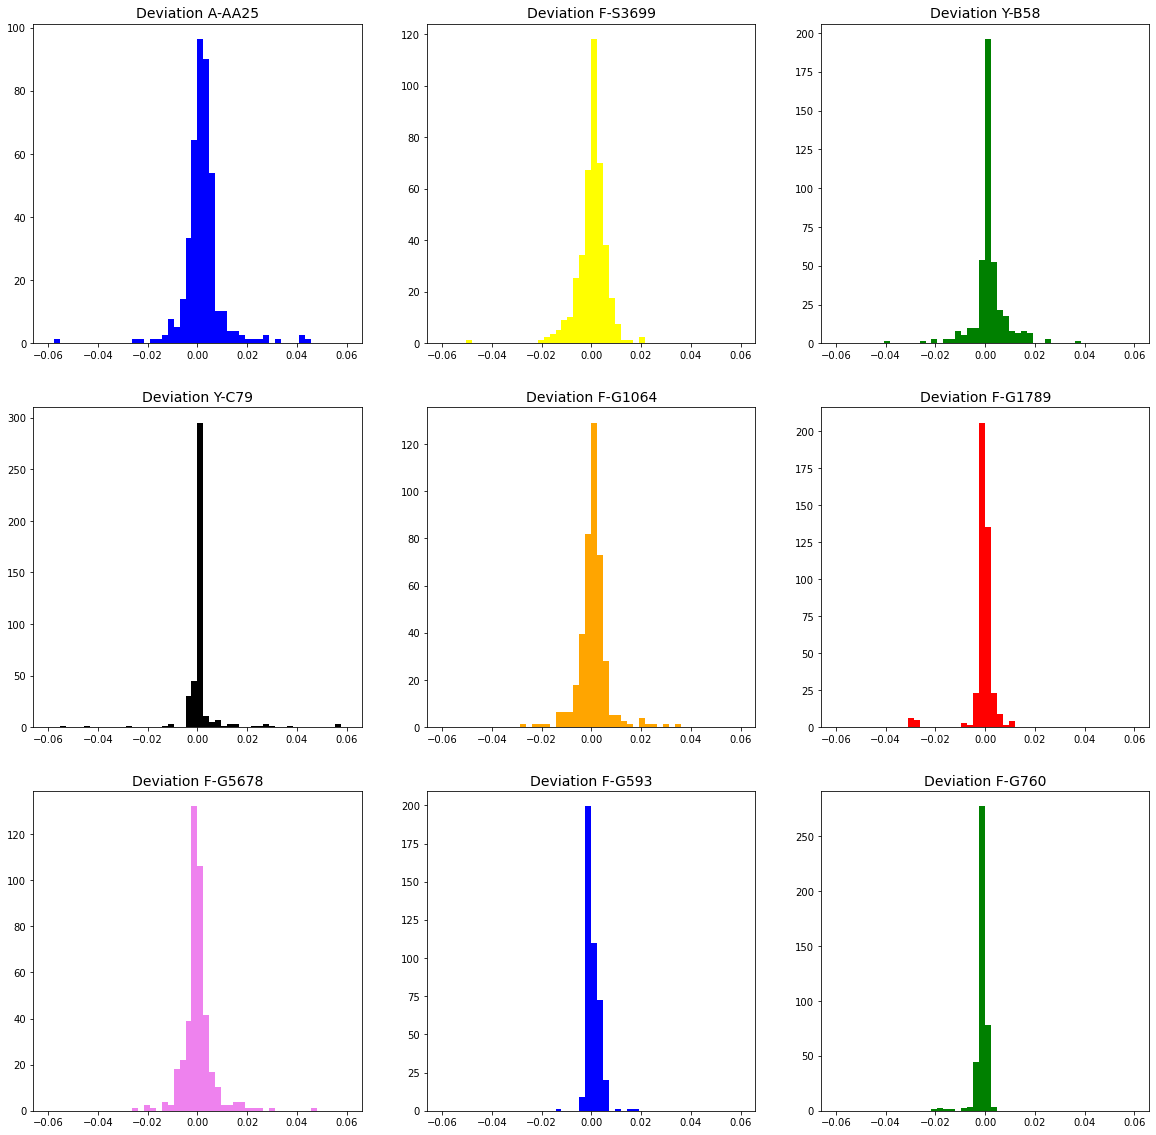

In [22]:
#Look at deviations per portfolio

deviation1 = df_fset[df_fset['PORTFOLIO_CODE'] == 'A-AA25']['DEVIATION_IN_PERCENT_OF_IBOR']
deviation2 = df_fset[df_fset['PORTFOLIO_CODE'] == 'F-S3699']['DEVIATION_IN_PERCENT_OF_IBOR']
deviation3 = df_fset[df_fset['PORTFOLIO_CODE'] == 'Y-B58']['DEVIATION_IN_PERCENT_OF_IBOR']
deviation4 = df_fset[df_fset['PORTFOLIO_CODE'] == 'Y-C79']['DEVIATION_IN_PERCENT_OF_IBOR']
deviation5 = df_fset[df_fset['PORTFOLIO_CODE'] == 'F-G1064']['DEVIATION_IN_PERCENT_OF_IBOR']
deviation6 = df_fset[df_fset['PORTFOLIO_CODE'] == 'F-G1789']['DEVIATION_IN_PERCENT_OF_IBOR']
deviation7 = df_fset[df_fset['PORTFOLIO_CODE'] == 'F-G5678']['DEVIATION_IN_PERCENT_OF_IBOR']
deviation8 = df_fset[df_fset['PORTFOLIO_CODE'] == 'F-G593']['DEVIATION_IN_PERCENT_OF_IBOR']
deviation9 = df_fset[df_fset['PORTFOLIO_CODE'] == 'F-G760']['DEVIATION_IN_PERCENT_OF_IBOR']


fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(3,3,1)
ax1.hist(deviation1, bins=50, range=(-0.06,+0.06), density=True, color='blue')
ax2 = fig.add_subplot(3,3,2)
ax2.hist(deviation2, bins=50, range=(-0.06,+0.06), density=True, color='yellow')
ax3 = fig.add_subplot(3,3,3)
ax3.hist(deviation3, bins=50, range=(-0.06,+0.06), density=True, color='green')
ax4 = fig.add_subplot(3,3,4)
ax4.hist(deviation4, bins=50, range=(-0.06,+0.06), density=True, color='black')
ax5 = fig.add_subplot(3,3,5)
ax5.hist(deviation5, bins=50, range=(-0.06,+0.06), density=True, color='orange')
ax6 = fig.add_subplot(3,3,6)
ax6.hist(deviation6, bins=50, range=(-0.06,+0.06), density=True, color='red')
ax7 = fig.add_subplot(3,3,7)
ax7.hist(deviation7, bins=50, range=(-0.06,+0.06), density=True, color='violet')
ax8 = fig.add_subplot(3,3,8)
ax8.hist(deviation8, bins=50, range=(-0.06,+0.06), density=True, color='blue')
ax9 = fig.add_subplot(3,3,9)
ax9.hist(deviation9, bins=50, range=(-0.06,+0.06), density=True, color='green')


ax1.set_title('Deviation A-AA25', fontsize=14);
ax2.set_title('Deviation F-S3699', fontsize=14);
ax3.set_title('Deviation Y-B58', fontsize=14);
ax4.set_title('Deviation Y-C79', fontsize=14);
ax5.set_title('Deviation F-G1064', fontsize=14);
ax6.set_title('Deviation F-G1789', fontsize=14);
ax7.set_title('Deviation F-G5678', fontsize=14);
ax8.set_title('Deviation F-G593', fontsize=14);
ax9.set_title('Deviation F-G760', fontsize=14);


In [23]:
# Which effective dates and portfolios have a high deviation
df_fset[df_fset['DEVIATION_IN_PERCENT_OF_IBOR'].abs() > 0.06 ]


,PORTFOLIO_CODE,EFFECTIVE_DATE,DEVIATION_IN_PERCENT_OF_IBOR,Africa,Americas,Asia,Europe,InternationalOrg,Oceania,unknown_reg,Cash,Debts,Equities,Forward,Funds,Futures,Listed Options,OTC Option,Rights,Swaps,unknown_atype
15,A-AA25,2019-11-25 00:00:00.000,-0.163688,0.000000,0.067662,1.100372,-0.168033,0.000000,0.000000,0.000000,-0.099933,0.000000,1.099937,-3.945307e-06,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
64,A-AA25,2020-02-06 00:00:00.000,-0.115819,0.000000,0.009091,1.107121,-0.116212,0.000000,0.000000,0.000000,-0.106705,0.000000,1.106705,5.881940e-07,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
178,A-AA25,2020-07-23 00:00:00.000,0.123417,0.000000,0.008690,0.863738,0.127572,0.000000,0.000000,0.000000,0.139607,0.000000,0.860389,4.420120e-06,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
180,A-AA25,2020-07-27 00:00:00.000,0.070646,0.000000,0.019913,0.914661,0.065427,0.000000,0.000000,0.000000,0.088667,0.000000,0.911329,4.737506e-06,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
479,F-G5678,2019-12-18 00:00:00.000,0.696252,0.000000,0.032474,0.027232,0.933657,0.000000,0.006637,0.000000,0.112518,0.425567,0.000000,0.000000e+00,0.461915,0.0,0.000000,0.000000,0.0,0.000000,0.000000
554,F-G5678,2020-01-15 00:00:00.000,-0.069828,0.000000,0.032440,0.027083,0.933810,0.000000,0.006667,0.000000,0.112920,0.425015,0.000000,0.000000e+00,0.462064,0.0,0.000000,0.000000,0.0,0.000000,0.000000
879,F-G5678,2020-04-17 00:00:00.000,0.378566,0.000000,0.046848,0.005243,0.942421,0.000000,0.005488,0.000000,0.517174,0.283393,0.000000,0.000000e+00,0.199433,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1479,F-G5678,2020-10-08 00:00:00.000,0.359929,0.000000,0.041336,0.001497,0.956949,0.000000,0.000218,0.000000,0.620435,0.221182,0.000000,0.000000e+00,0.158384,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2480,Y-B58,2020-08-14 00:00:00.000,0.064445,0.000000,0.090227,0.019042,0.875282,0.015450,0.000000,0.000000,0.101933,0.885029,0.000000,4.766341e-05,0.012990,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2621,Y-C79,2019-11-13 00:00:00.000,0.070606,0.004268,-0.025067,0.002379,1.013823,0.006241,-0.007667,0.006023,0.091184,0.834805,0.000000,-6.521263e-04,0.078729,0.0,0.000155,-0.003492,0.0,-0.000729,0.000000


In [24]:
# Check aggregated deviations in the time series
# group by effective date

df2 = df_fset[['EFFECTIVE_DATE', 'DEVIATION_IN_PERCENT_OF_IBOR']]

by_date= df2.groupby('EFFECTIVE_DATE')

df_ts_dev= pd.DataFrame(by_date.sum())

df_ts_dev.head(10)


,DEVIATION_IN_PERCENT_OF_IBOR
EFFECTIVE_DATE,
2019-11-04 00:00:00.000,0.006939
2019-11-05 00:00:00.000,0.004914
2019-11-06 00:00:00.000,0.007619
2019-11-07 00:00:00.000,0.003486
2019-11-08 00:00:00.000,-0.000128
2019-11-11 00:00:00.000,-0.006661
2019-11-12 00:00:00.000,-0.002712
2019-11-13 00:00:00.000,0.081177
2019-11-14 00:00:00.000,-0.005818


<AxesSubplot:xlabel='EFFECTIVE_DATE'>

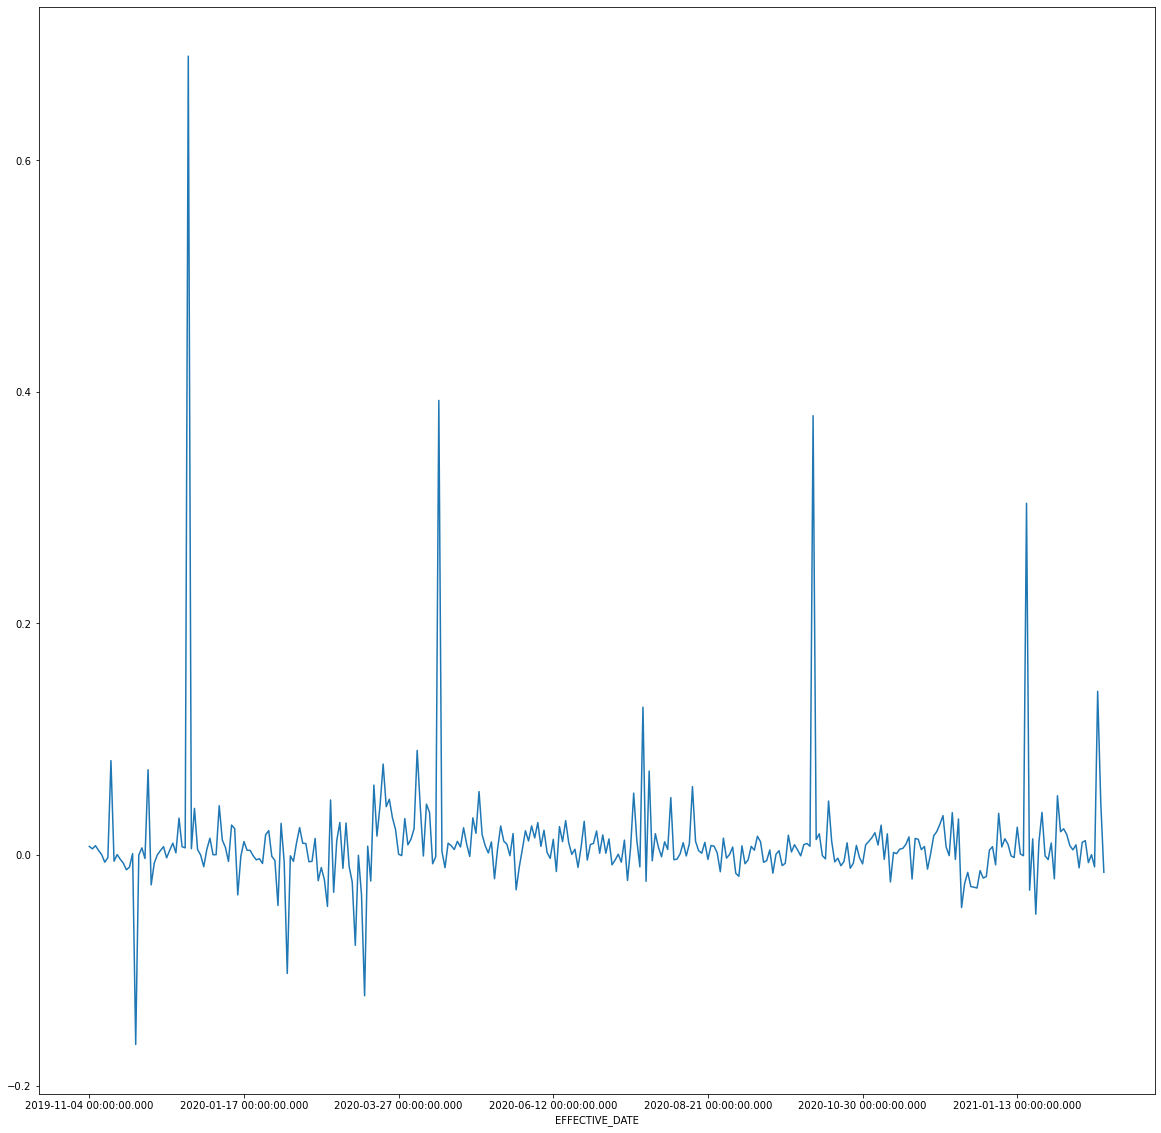

In [25]:
# Plot aggregated deviation per day

fig = plt.figure(figsize=(20,20))

df_ts_dev['DEVIATION_IN_PERCENT_OF_IBOR'].plot()

In [26]:
# Check which dates have a high deviation. Was something wrong on theses days?
df_ts_dev[df_ts_dev['DEVIATION_IN_PERCENT_OF_IBOR'].abs() > 0.3]

,DEVIATION_IN_PERCENT_OF_IBOR
EFFECTIVE_DATE,
2019-12-18 00:00:00.000,0.690168
2020-04-17 00:00:00.000,0.392538
2020-10-08 00:00:00.000,0.379313
2021-01-18 00:00:00.000,0.303620



# 2 dimensional analysis of data


In [27]:
#Pairplot with label outlier = deviation > 2 * std

df_fset['Statistical Outlier']  = df_fset['DEVIATION_IN_PERCENT_OF_IBOR'].apply(lambda x: 'True' if np.abs(x) > 2*deviation_std else 'False')

df_fset

,PORTFOLIO_CODE,EFFECTIVE_DATE,DEVIATION_IN_PERCENT_OF_IBOR,Africa,Americas,Asia,Europe,InternationalOrg,Oceania,unknown_reg,Cash,Debts,Equities,Forward,Funds,Futures,Listed Options,OTC Option,Rights,Swaps,unknown_atype,Statistical Outlier
0,A-AA25,2019-11-04 00:00:00.000,0.002970,0.000000,0.011357,0.988471,0.000172,0.000000,0.000000,0.000000,0.012110,0.000000,0.987858,0.000032,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False
1,A-AA25,2019-11-05 00:00:00.000,0.002345,0.000000,0.015185,0.984543,0.000273,0.000000,0.000000,0.000000,0.015321,0.000000,0.984646,0.000033,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False
2,A-AA25,2019-11-06 00:00:00.000,0.003562,0.000000,0.014814,0.985091,0.000095,0.000000,0.000000,0.000000,0.015344,0.000000,0.984623,0.000033,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False
3,A-AA25,2019-11-07 00:00:00.000,0.003203,0.000000,0.014541,0.986265,-0.000805,0.000000,0.000000,0.000000,0.014469,0.000000,0.985497,0.000034,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False
4,A-AA25,2019-11-08 00:00:00.000,0.002548,0.000000,0.013950,0.986083,-0.000033,0.000000,0.000000,0.000000,0.014526,0.000000,0.985441,0.000033,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,Y-C79,2021-02-16 00:00:00.000,0.000721,0.004097,-0.037878,0.007094,1.016775,0.017723,-0.009849,0.002039,0.025186,0.932779,0.000000,-0.000026,0.039785,0.0,0.000407,0.000040,0.0,-0.000209,0.002039,False
2938,Y-C79,2021-02-17 00:00:00.000,0.000904,0.004093,-0.038449,0.007101,1.012325,0.017742,-0.008595,0.005784,0.023690,0.931260,0.000000,-0.000636,0.039752,0.0,0.000314,0.000047,0.0,-0.000211,0.005784,False
2939,Y-C79,2021-02-18 00:00:00.000,0.161601,0.003425,-0.032192,0.005950,1.003198,0.018038,-0.007143,0.008725,0.010719,0.947442,0.000000,-0.000277,0.033332,0.0,0.000198,0.000044,0.0,-0.000183,0.008725,True
2940,Y-C79,2021-02-19 00:00:00.000,0.060841,0.003207,-0.029873,0.005580,1.002579,0.016958,-0.006835,0.008383,0.070780,0.889600,0.000000,-0.000152,0.031308,0.0,0.000232,0.000032,0.0,-0.000184,0.008383,True


<Figure size 1440x1440 with 0 Axes>

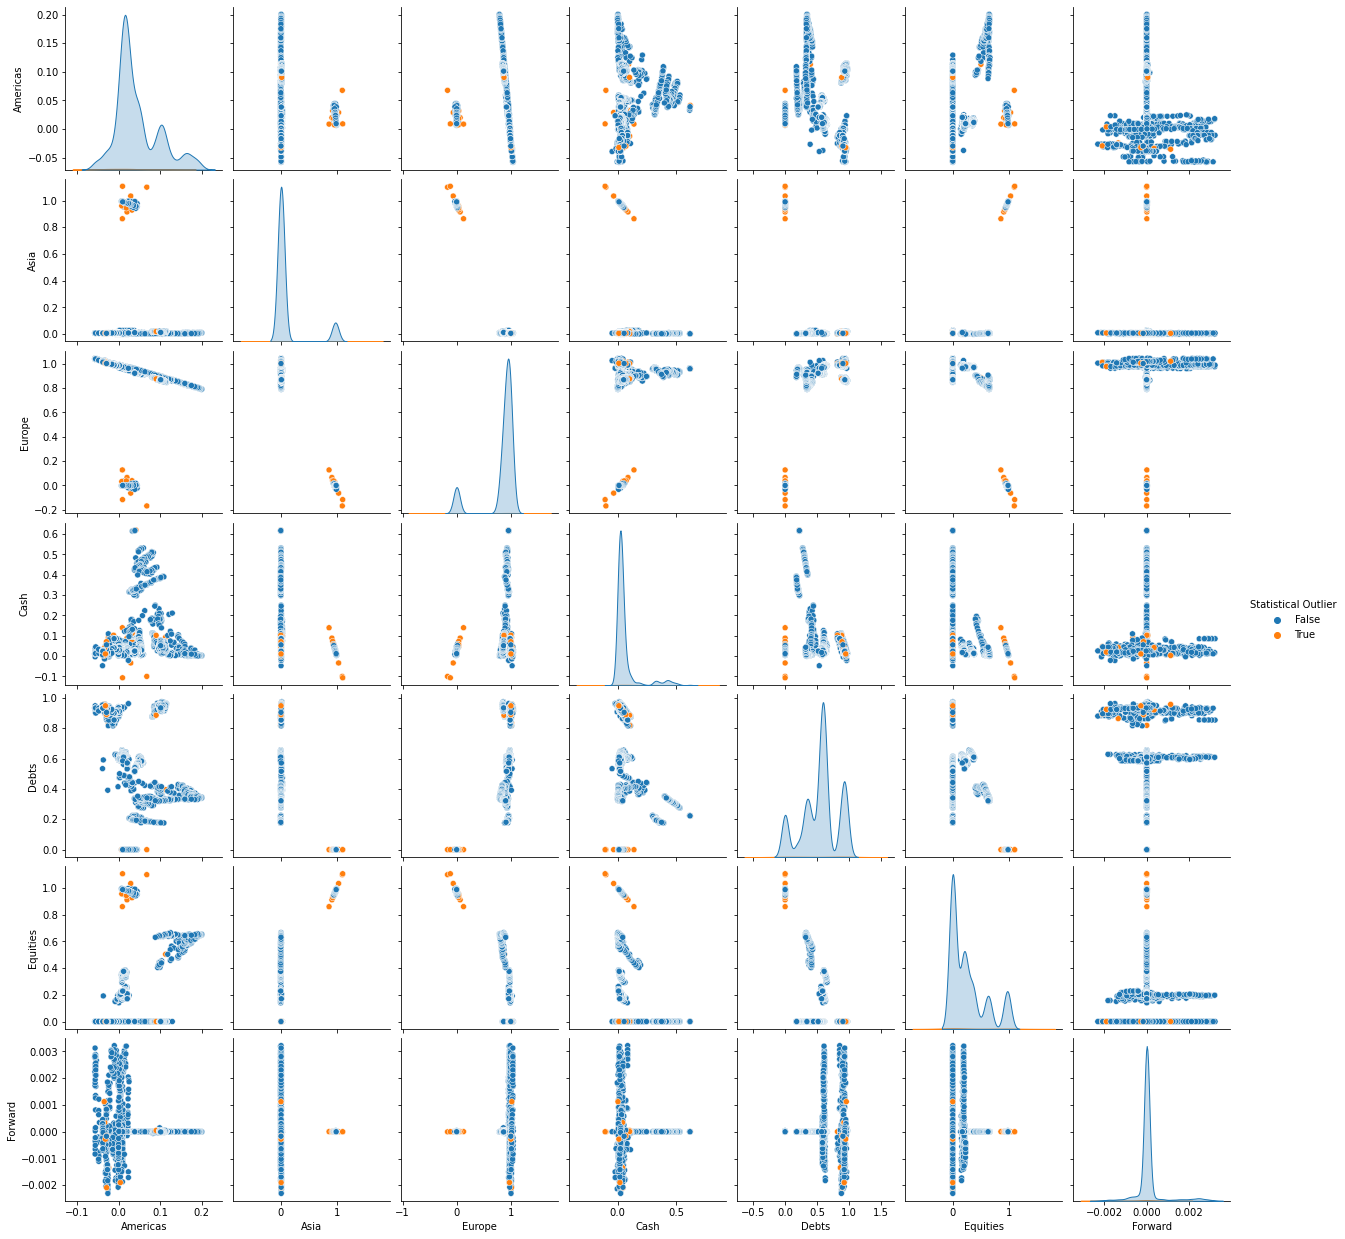

In [28]:
# Pairplot with label statistical outlier
plt.figure(figsize=(20, 20))

# plot a pairplot of the distinct feature distributions
sns.pairplot( df_fset[['Americas', 'Asia', 'Europe','Cash', 'Debts' ,'Equities', 'Forward', 'Statistical Outlier']], hue='Statistical Outlier')


=================================
Dimension Reduction via PCA
==================================

In [29]:
from sklearn import datasets
from sklearn.decomposition import PCA

In [30]:
#PCA on normalized data with number of components = max. number of features
# to get out the variance ratio of the components 
pca=PCA(n_components=19)
pca.fit(df_norm)

pca.explained_variance_ratio_


array([7.32157197e-01, 1.20449695e-01, 1.08123853e-01, 2.94306803e-02,
       8.03396114e-03, 9.19603084e-04, 7.34823397e-04, 9.88829703e-05,
       3.63947250e-05, 9.12719331e-06, 2.58338774e-06, 1.51158517e-06,
       8.56069424e-07, 4.41020522e-07, 2.48483990e-07, 1.27424236e-07,
       1.29907185e-08, 6.27137235e-10, 1.52377877e-32])

In [31]:
# Only 2 components have almost 100% of the variance of the normalized data

# PCA with reduction to 2 components

pca=PCA(n_components=2)
pca.fit(df_norm)

pca.components_

array([[ 1.47861885e-04, -5.65881158e-04,  4.06900492e-03,
         4.94933404e-01, -5.54176518e-01, -7.97197947e-03,
         9.96203994e-04, -4.53339229e-04, -3.52127671e-02,
        -4.09814932e-01,  5.11730962e-01, -6.35857311e-05,
        -1.29578936e-01, -2.74789802e-07, -3.79455897e-04,
         3.83055209e-05, -1.49959223e-06,  1.32641496e-04,
        -1.95623415e-05],
       [ 4.02937112e-03, -1.30116044e-03, -3.60300441e-02,
         1.58520468e-01, -1.80951596e-02, -3.16139524e-03,
         7.26295693e-03, -9.40148745e-04,  3.61089283e-01,
        -5.13360854e-01, -3.94097545e-01, -1.15495620e-04,
         6.51094673e-01, -1.50122559e-07,  1.42590278e-03,
         6.61181429e-05, -4.57262668e-05,  2.50881410e-04,
        -5.15712388e-05]])

In [32]:
# check / show what the components mean

print("Square root of sum of squares of vector1 values: ", np.sqrt(np.sum(pca.components_[0]**2)))
print("Square root of sum of squares of vector1 values: ", np.sqrt(np.sum(pca.components_[1]**2)))


pca.components_

Square root of sum of squares of vector1 values:  0.9999999999999998
Square root of sum of squares of vector1 values:  1.0


array([[ 1.47861885e-04, -5.65881158e-04,  4.06900492e-03,
         4.94933404e-01, -5.54176518e-01, -7.97197947e-03,
         9.96203994e-04, -4.53339229e-04, -3.52127671e-02,
        -4.09814932e-01,  5.11730962e-01, -6.35857311e-05,
        -1.29578936e-01, -2.74789802e-07, -3.79455897e-04,
         3.83055209e-05, -1.49959223e-06,  1.32641496e-04,
        -1.95623415e-05],
       [ 4.02937112e-03, -1.30116044e-03, -3.60300441e-02,
         1.58520468e-01, -1.80951596e-02, -3.16139524e-03,
         7.26295693e-03, -9.40148745e-04,  3.61089283e-01,
        -5.13360854e-01, -3.94097545e-01, -1.15495620e-04,
         6.51094673e-01, -1.50122559e-07,  1.42590278e-03,
         6.61181429e-05, -4.57262668e-05,  2.50881410e-04,
        -5.15712388e-05]])

[[ 1.14675984  0.05510884]
 [ 1.14661827  0.05571581]
 [ 1.14668451  0.05584962]
 ...
 [-0.24525304 -0.12388979]
 [-0.25208081 -0.0987285 ]
 [-0.25220972 -0.10687942]]


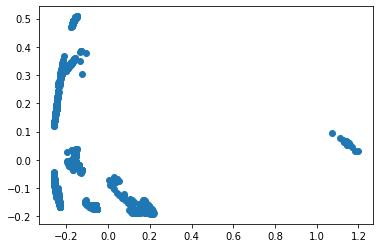

In [33]:
# PCA transformation of the data

df_trans=pca.transform(df_norm)

df_fset['PCA Trans X'] = df_trans[:,0]
df_fset['PCA Trans Y'] = df_trans[:,1]

print(df_trans)

plt.scatter(df_trans[:,0], df_trans[:,1])

In [34]:
df_fset

,PORTFOLIO_CODE,EFFECTIVE_DATE,DEVIATION_IN_PERCENT_OF_IBOR,Africa,Americas,Asia,Europe,InternationalOrg,Oceania,unknown_reg,Cash,Debts,Equities,Forward,Funds,Futures,Listed Options,OTC Option,Rights,Swaps,unknown_atype,Statistical Outlier,PCA Trans X,PCA Trans Y
0,A-AA25,2019-11-04 00:00:00.000,0.002970,0.000000,0.011357,0.988471,0.000172,0.000000,0.000000,0.000000,0.012110,0.000000,0.987858,0.000032,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.146760,0.055109
1,A-AA25,2019-11-05 00:00:00.000,0.002345,0.000000,0.015185,0.984543,0.000273,0.000000,0.000000,0.000000,0.015321,0.000000,0.984646,0.000033,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.146618,0.055716
2,A-AA25,2019-11-06 00:00:00.000,0.003562,0.000000,0.014814,0.985091,0.000095,0.000000,0.000000,0.000000,0.015344,0.000000,0.984623,0.000033,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.146685,0.055850
3,A-AA25,2019-11-07 00:00:00.000,0.003203,0.000000,0.014541,0.986265,-0.000805,0.000000,0.000000,0.000000,0.014469,0.000000,0.985497,0.000034,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.147069,0.055695
4,A-AA25,2019-11-08 00:00:00.000,0.002548,0.000000,0.013950,0.986083,-0.000033,0.000000,0.000000,0.000000,0.014526,0.000000,0.985441,0.000033,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.146763,0.055687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,Y-C79,2021-02-16 00:00:00.000,0.000721,0.004097,-0.037878,0.007094,1.016775,0.017723,-0.009849,0.002039,0.025186,0.932779,0.000000,-0.000026,0.039785,0.0,0.000407,0.000040,0.0,-0.000209,0.002039,False,-0.251383,-0.114228
2938,Y-C79,2021-02-17 00:00:00.000,0.000904,0.004093,-0.038449,0.007101,1.012325,0.017742,-0.008595,0.005784,0.023690,0.931260,0.000000,-0.000636,0.039752,0.0,0.000314,0.000047,0.0,-0.000211,0.005784,False,-0.251242,-0.115029
2939,Y-C79,2021-02-18 00:00:00.000,0.161601,0.003425,-0.032192,0.005950,1.003198,0.018038,-0.007143,0.008725,0.010719,0.947442,0.000000,-0.000277,0.033332,0.0,0.000198,0.000044,0.0,-0.000183,0.008725,True,-0.245253,-0.123890
2940,Y-C79,2021-02-19 00:00:00.000,0.060841,0.003207,-0.029873,0.005580,1.002579,0.016958,-0.006835,0.008383,0.070780,0.889600,0.000000,-0.000152,0.031308,0.0,0.000232,0.000032,0.0,-0.000184,0.008383,True,-0.252081,-0.098728






# KMeans Clustering  





In [35]:
# KMeans Clustering with 

no_clusters = 5
init_means = np.array([[0.5, 0.5], [0.1, 0.1], [-0.3, -0.3],[-0.2,-0.2], [0.0, 0.5]])
max_iterations = 20


kmeans = KMeans(n_clusters=no_clusters, init=init_means, max_iter=max_iterations)

kmeans.fit(df_trans)



/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KMeans(init=array([[ 0.5,  0.5],
       [ 0.1,  0.1],
       [-0.3, -0.3],
       [-0.2, -0.2],
       [ 0. ,  0.5]]),
       max_iter=20, n_clusters=5)

In [36]:
labels = kmeans.labels_ # obtain the assigned cluster labels
print(labels.shape)

df_fset['KMEANS Label'] = labels

df_fset

(2942,)


,PORTFOLIO_CODE,EFFECTIVE_DATE,DEVIATION_IN_PERCENT_OF_IBOR,Africa,Americas,Asia,Europe,InternationalOrg,Oceania,unknown_reg,Cash,Debts,Equities,Forward,Funds,Futures,Listed Options,OTC Option,Rights,Swaps,unknown_atype,Statistical Outlier,PCA Trans X,PCA Trans Y,KMEANS Label
0,A-AA25,2019-11-04 00:00:00.000,0.002970,0.000000,0.011357,0.988471,0.000172,0.000000,0.000000,0.000000,0.012110,0.000000,0.987858,0.000032,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.146760,0.055109,0
1,A-AA25,2019-11-05 00:00:00.000,0.002345,0.000000,0.015185,0.984543,0.000273,0.000000,0.000000,0.000000,0.015321,0.000000,0.984646,0.000033,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.146618,0.055716,0
2,A-AA25,2019-11-06 00:00:00.000,0.003562,0.000000,0.014814,0.985091,0.000095,0.000000,0.000000,0.000000,0.015344,0.000000,0.984623,0.000033,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.146685,0.055850,0
3,A-AA25,2019-11-07 00:00:00.000,0.003203,0.000000,0.014541,0.986265,-0.000805,0.000000,0.000000,0.000000,0.014469,0.000000,0.985497,0.000034,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.147069,0.055695,0
4,A-AA25,2019-11-08 00:00:00.000,0.002548,0.000000,0.013950,0.986083,-0.000033,0.000000,0.000000,0.000000,0.014526,0.000000,0.985441,0.000033,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.146763,0.055687,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,Y-C79,2021-02-16 00:00:00.000,0.000721,0.004097,-0.037878,0.007094,1.016775,0.017723,-0.009849,0.002039,0.025186,0.932779,0.000000,-0.000026,0.039785,0.0,0.000407,0.000040,0.0,-0.000209,0.002039,False,-0.251383,-0.114228,3
2938,Y-C79,2021-02-17 00:00:00.000,0.000904,0.004093,-0.038449,0.007101,1.012325,0.017742,-0.008595,0.005784,0.023690,0.931260,0.000000,-0.000636,0.039752,0.0,0.000314,0.000047,0.0,-0.000211,0.005784,False,-0.251242,-0.115029,3
2939,Y-C79,2021-02-18 00:00:00.000,0.161601,0.003425,-0.032192,0.005950,1.003198,0.018038,-0.007143,0.008725,0.010719,0.947442,0.000000,-0.000277,0.033332,0.0,0.000198,0.000044,0.0,-0.000183,0.008725,True,-0.245253,-0.123890,3
2940,Y-C79,2021-02-19 00:00:00.000,0.060841,0.003207,-0.029873,0.005580,1.002579,0.016958,-0.006835,0.008383,0.070780,0.889600,0.000000,-0.000152,0.031308,0.0,0.000232,0.000032,0.0,-0.000184,0.008383,True,-0.252081,-0.098728,3


In [37]:
# KMEANS means
means = kmeans.cluster_centers_ # obtain the assigned cluster means 
print(means)      

[[ 1.14572905  0.05888264]
 [ 0.16906061 -0.16660793]
 [ 1.18457502  0.03522071]
 [-0.17587818 -0.08796942]
 [-0.22030316  0.27464459]]


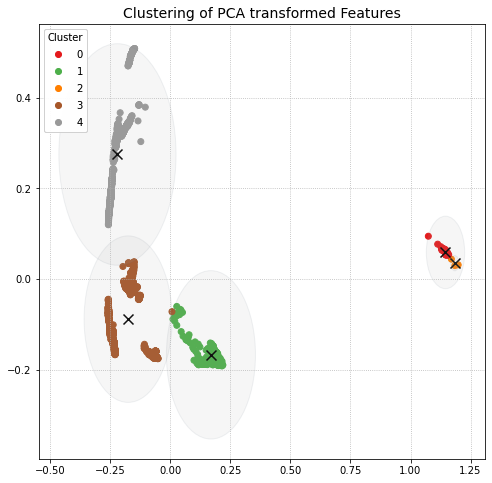

In [38]:
# init the KMEANS plot for the PCA transformed 2 dim data

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

#c=labels.astype(np.float)
#print(c.shape)
#print(df_t1[:,0].shape)
#df_t1

# plot petal length vs. petal width and corresponding classes
scatter = ax.scatter(df_trans[:,0], df_trans[:,1], c=labels.astype(np.float), cmap=plt.cm.Set1)

# prepare data legend
legend = ax.legend(*scatter.legend_elements(), loc='upper left', title='Cluster')

# add legend to plot
ax.add_artist(legend)

# plot cluster means
ax.scatter(means[:,0], means[:,1], marker='x', c='black', s=100)

# iterate over distinct cluster means
for i, mean in enumerate(means):
    
    # determine max cluster point distance
    cluster_radi = cdist(df_trans[labels==i], [mean]).max()
    
    # plot cluster size
    ax.add_patch(plt.Circle(mean, cluster_radi, fc='darkgrey', edgecolor='slategrey', lw=1, alpha=0.1, zorder=1))

# add plot title
plt.title('Clustering of PCA transformed Features', fontsize=14);


# LOF Local Outlier Factor

Another efficient way to perform outlier detection on moderately high dimensional datasets is to use the Local Outlier Factor (LOF) algorithm.

The neighbors.LocalOutlierFactor (LOF) algorithm computes a score (called local outlier factor) reflecting the degree of abnormality of the observations. It measures the local density deviation of a given data point with respect to its neighbors. The idea is to detect the samples that have a substantially lower density than their neighbors.

In practice the local density is obtained from the k-nearest neighbors. The LOF score of an observation is equal to the ratio of the average local density of his k-nearest neighbors, and its own local density: a normal instance is expected to have a local density similar to that of its neighbors, while abnormal data are expected to have much smaller local density.

The number k of neighbors considered, (alias parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general. When the proportion of outliers is high (i.e. greater than 10 %, as in the example below), n_neighbors should be greater (n_neighbors=35 in the example below).

The strength of the LOF algorithm is that it takes both local and global properties of datasets into consideration: it can perform well even in datasets where abnormal samples have different underlying densities. The question is not, how isolated the sample is, but how isolated it is with respect to the surrounding neighborhood. 

When applying LOF for outlier detection, there are no predict, decision_function and score_samples methods but only a fit_predict method. The scores of abnormality of the training samples are accessible through the negative_outlier_factor_ attribute. Note that predict, decision_function and score_samples can be used on new unseen data when LOF is applied for novelty detection, i.e. when the novelty parameter is set to True. See Novelty detection with Local Outlier Factor



In [39]:
#Normalized or normal data into LOF????????

from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

clf = LocalOutlierFactor(n_neighbors=20)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(df_norm)
#n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

In [40]:
#Check prediction of local outliers

print(y_pred.shape)

y_pred1 = pd.DataFrame(y_pred)

#y_pred2 = y_pred[y_pred==-1]
#print(pd.DataFrame(y_pred2).count)df_fset['LOF Outlier'] = y_pred

y_pred2 = y_pred1[0]==-1


df_fset['LOF Local Outlier'] = y_pred2

(2942,)


In [41]:
df_fset[df_fset['LOF Local Outlier'] == True]

,PORTFOLIO_CODE,EFFECTIVE_DATE,DEVIATION_IN_PERCENT_OF_IBOR,Africa,Americas,Asia,Europe,InternationalOrg,Oceania,unknown_reg,Cash,Debts,Equities,Forward,Funds,Futures,Listed Options,OTC Option,Rights,Swaps,unknown_atype,Statistical Outlier,PCA Trans X,PCA Trans Y,KMEANS Label,LOF Local Outlier
15,A-AA25,2019-11-25 00:00:00.000,-0.163688,0.000000,0.067662,1.100372,-0.168033,0.000000,0.000000,0.000000,-0.099933,0.000000,1.099937,-3.945307e-06,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,True,1.198534,0.031651,2,True
19,A-AA25,2019-11-29 00:00:00.000,0.006889,0.000000,0.019458,0.980813,-0.000271,0.000000,0.000000,0.000000,0.025256,0.000000,0.974748,-3.728767e-06,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.146441,0.059502,0,True
31,A-AA25,2019-12-17 00:00:00.000,0.005477,0.000000,0.016261,0.978710,0.005028,0.000000,0.000000,0.000000,0.021553,0.000000,0.978448,-8.683260e-07,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.144495,0.057369,0,True
42,A-AA25,2020-01-07 00:00:00.000,0.026974,0.000000,0.016052,0.958933,0.025016,0.000000,0.000000,0.000000,0.041807,0.000000,0.958190,2.744127e-06,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.135250,0.062882,0,True
48,A-AA25,2020-01-15 00:00:00.000,0.031673,0.000000,0.011769,0.952782,0.035449,0.000000,0.000000,0.000000,0.046341,0.000000,0.953653,6.030560e-06,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,False,1.130547,0.063866,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,Y-C79,2021-01-19 00:00:00.000,-0.044293,0.003948,-0.035253,0.005266,1.020621,0.014689,-0.009271,0.000000,0.002925,0.956853,0.000000,1.123744e-03,0.038675,0.0,0.000351,0.000127,0.0,-0.000054,0.000000,True,-0.250352,-0.125112,3,True
2919,Y-C79,2021-01-21 00:00:00.000,-0.053836,0.004163,-0.038793,0.007273,1.021689,0.015502,-0.009834,0.000000,0.010263,0.948520,0.000000,1.599897e-04,0.040772,0.0,0.000233,0.000104,0.0,-0.000052,0.000000,True,-0.250152,-0.119973,3,True
2939,Y-C79,2021-02-18 00:00:00.000,0.161601,0.003425,-0.032192,0.005950,1.003198,0.018038,-0.007143,0.008725,0.010719,0.947442,0.000000,-2.766960e-04,0.033332,0.0,0.000198,0.000044,0.0,-0.000183,0.008725,True,-0.245253,-0.123890,3,True
2940,Y-C79,2021-02-19 00:00:00.000,0.060841,0.003207,-0.029873,0.005580,1.002579,0.016958,-0.006835,0.008383,0.070780,0.889600,0.000000,-1.520307e-04,0.031308,0.0,0.000232,0.000032,0.0,-0.000184,0.008383,True,-0.252081,-0.098728,3,True
